imports and pre processing

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)


directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [2]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('\n')
    print('**Remove Extreme (hig,low) Weights**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df

#source: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py 

from matplotlib.lines import Line2D
def long_tail_plot(df, item_id_column, percentage=0.75):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)

    Returns:
    -------
        A long tail plot
    """
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
    
    #line plot of cumulative volume
    ax=sns.lineplot(x = 'index', y="volume", data=volume_df.reset_index(), color="black")
    #set labels
    ax.set_title('Long Tail Plot of User weights by Artist')
    ax.set_ylabel('# of user weights')
    ax.set_xlabel(item_id_column)
    plt.tick_params(labelbottom = False)
    
    #plot vertical line at the tail location
    head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
    tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
    items_in_head = len(head)
    items_in_tail = len(tail)
    plt.axvline(x=items_in_head, color="red",  linestyle='--')

    # fill area under plot
    head = head.append(tail.head(1))
    x1 = head.index.values
    y1 = head['volume']
    x2 = tail.index.values
    y2 = tail['volume']
    ax.fill_between(x1, y1, color="blue", alpha=0.2)
    ax.fill_between(x2, y2,  color="orange", alpha=0.2)

    #create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': artists in the head', markerfacecolor='blue', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': artists in the tail', markerfacecolor='orange', markersize=5)]
    ax.legend(handles=legend_elements, loc=1)

    plt.show()
    
    
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top count of users (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Highly Popular Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)

    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of tot Users per Artist')
    #plt.ylabel('count of users')
    #plt.show()
    pct_plot = 0.8
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users): ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['count'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Distribution of tot Users per Artist - Filtered Dataset')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',pct_plot)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users) - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df


def remove_rare_artists(df,artist_df,min_users):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    min_users: minimum number of users each artist must have 
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Rare Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    pct_plot = 0.8
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    #threshold = artists_group['count'].quantile(pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] < min_users].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',0.8)
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df


#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('\n')
    print('**Remove User with lowcount of samples (artists)**')
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df

#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('\n')
    print('**Scaling**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    #adding 0.01 to provent 0 values
    scaled_df['weight'] = scaled_df['weight'] + 0.01
    #to handle 0 division
    scaled_df['weight'] = scaled_df['weight'].fillna(0.5)
    
    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df

def train_test_split(df,sample_size,seed=1):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    
    sample_size must be smaller than total artist count per user!!!
    
    '''  
    print('\n')
    print('**Train-Test Split**')
    print(f"input data shape: {df.shape}")
    
    np.random.seed(seed)
    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")
    print('\n')
    #all test artists must be part of the training data
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    diff = np.setdiff1d(unique_test,unique_train)
    if len(diff)>1:
        print(f"WARNING: {len(diff)} artists from the test set are not on the train set")
        print('1.consider increasing the min count of users per artist when pre-processing')
        print('2.consider decreasing the number of samples per user for train-test split')
        print('3.as al ast resource consider changing your seed')
    else:
        print('OK: all artists from the test set are part on the train set as well')
    return train, test



#show top n per user
#Merging some tables 
df_scrobbles = weights_df.merge(artist_df[['id','name']],
                                        how = 'inner',
                                        left_on = 'artistID',
                                        right_on = 'id')
df_scrobbles = df_scrobbles.drop(columns=['id'])
df_scrobbles.columns = ['userID','artistID','weight','name']
print(df_scrobbles.shape)

def get_top_artists(user_id,n=5):
    top_list = df_scrobbles[df_scrobbles['userID']==user_id].sort_values(by='weight')['name'].head(n)      
    return list(top_list)

(92834, 4)


### Data Preprocessing: 




**Remove Extreme (hig,low) Weights**
df original shape:  (92834, 3)


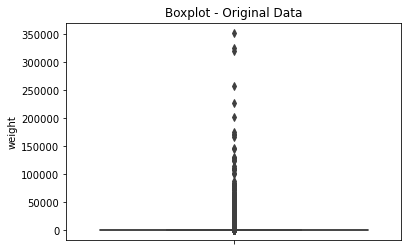

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (92204, 3)


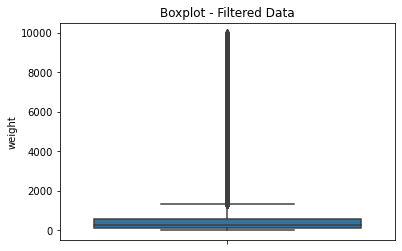

filtered data - stats:
count   92204.000
mean      562.005
std       936.382
min         1.000
25%       106.000
50%       257.000
75%       601.000
max     10000.000
Name: weight, dtype: float64


% of removed records: 0.0068


**Remove Highly Popular Artists**
input data shape: (92204, 3)
unique artists:  17623
line divides top 80.0 % cumulative sum of users:


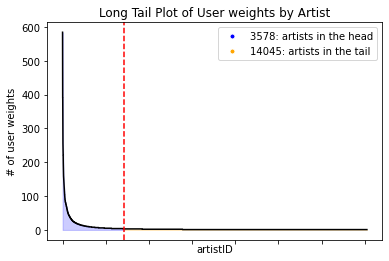

top 10 artists (most users): 
61                Madonna
83              Lady Gaga
148             Radiohead
184                  Muse
221           The Beatles
282               Rihanna
283        Britney Spears
286    Christina Aguilera
294            Katy Perry
327         Avril Lavigne
Name: name, dtype: object


total removed artists: 176


line divides top 80.0 % cumulative sum of users:


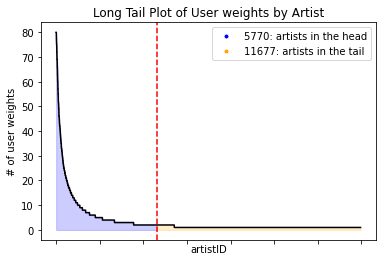

top 10 artists (most users) - filtered dataset: 
91                    Duffy
259             Céline Dion
424               Kate Nash
540          The Ting Tings
612     Belle and Sebastian
799            Rise Against
845         Alice in Chains
1122                   Tool
1368               The Fray
2068                 M.I.A.
Name: name, dtype: object


filtered dataset shape: (63360, 3)
unique artists after removal:  17447
% of removed records: 0.3128


**Remove Rare Artists**
input data shape: (63360, 3)
unique artists:  17447
line divides top 80.0 % cumulative sum of users:


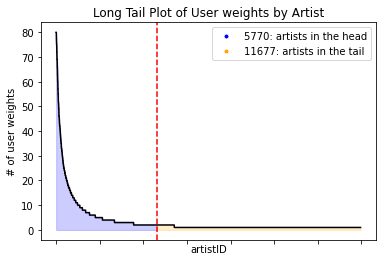

bottom 10 artists: 
9159                  Dam
9160               Donnis
9161            Paul Wall
9162           Ziad Borji
9163           ئلبي وعمري
9165        Carole Samaha
9166     David Arkenstone
9169          Alan Menken
9170              Karmina
17631    Grzegorz Tomczak
Name: name, dtype: object


total removed artists: 14799


line divides top 80.0 % cumulative sum of users:


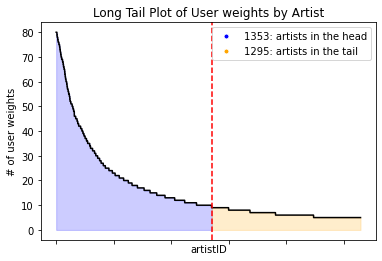

bottom 10 artists - filtered dataset: 
33                    Dawn of Ashes
705                   Mark Knopfler
2887                         Redman
4144    Everything Is Made in China
4158                  QUEST PISTOLs
4180                   Every Avenue
6319                     I Am Ghost
6330                         Djavan
6392                           2ois
6406                    I:Scintilla
Name: name, dtype: object


filtered dataset shape: (41966, 3)
unique artists after removal:  2648
% of removed records: 0.3377


**Remove artists not present in Spotify Dataset**
unique artists before join:  2648
original df:  (41966, 3)
new df:  (32129, 3)
unique artists after join:  1726
removed records %: 0.2344040413668208


**Remove User with lowcount of samples (artists)**
df original shape:  (41966, 3)
unique users:  1879
users with less than 10 artists: 82
unique users after removal:  1797
df new shape:  (41503, 3)
% of removed records: 0.011


In [3]:
#remove extremely high play counts +20K
df = remove_extreme_weights (weights_df,1,10000)

#remove highly popular artists - Top 1%
df = remove_popular_artists (df,artist_df,0.01)

#remove rare artist less than 3 users
df = remove_rare_artists (df,artist_df,min_users = 5)


#inner join with spotify data - DO NOT REMOVE THEM
print('\n')
print('**Remove artists not present in Spotify Dataset**')
print('unique artists before join: ',df['artistID'].nunique())
merge_df = artist_df.merge(artist_sp_df['artists'],
                               how = 'inner',
                               left_on = artist_df['name'].str.lower(),
                               right_on = artist_sp_df['artists'].str.lower())
artist_list = list(merge_df['id'])
print('original df: ',df.shape)
new_df = df[df['artistID'].isin(artist_list)]
print('new df: ',new_df.shape)
print('unique artists after join: ',new_df['artistID'].nunique())
print(f'removed records %: {1-(new_df.shape[0]/df.shape[0])}')

#remove users who have listened to less than 10 artists
df = remove_users_lowcount (df,min_artists = 10) #not removing SPOTIFY missing artists


In [4]:
#scaling
#df = scale_weight_by_user(df)

### train/test

In [5]:
#5 samples per user
train, test = train_test_split(df,sample_size=5,seed=1990)



**Train-Test Split**
input data shape: (41503, 3)
train set shape: (32518, 3)
test set shape: (8985, 3)


OK: all artists from the test set are part on the train set as well


### Train Data Matrix

In [6]:
#Sparse matrix, we need to pivot the data
data_pivot = train.pivot(index='userID',
                                       columns='artistID').fillna(0).astype(int)
#data_pivot.head()

#Trying to make it more memory efficient
# create scipy sparse from pivot tables
#from scipy import sparse
#data_sparse = sparse.csr_matrix(data_pivot)
#data_sparse.shape

In [7]:
#save IDS
artist_ids = list(data_pivot.columns.get_level_values(1))
user_ids = list(data_pivot.index)

print(len(user_ids))
print(len(artist_ids))



1797
2647


## Colaborative Filtering

Cosine Similarity

In [8]:
from sklearn.metrics import pairwise_distances
#similarities are obtained by subtracting distances from 1
cosine_sim = 1-pairwise_distances(data_pivot, metric="cosine")

Pearson Correlation

In [9]:
from sklearn.metrics import pairwise_distances
#get pearson similarities for ratings matrix M
pearson_sim = 1-pairwise_distances(data_pivot, metric="correlation")

In [10]:
#Subjective Testing using the matrix - SKLEARN - FOR RANDOM USER

similarities = cosine_sim
#similarities = pearson_sim

k = 5
user = np.random.choice(similarities.shape[0])#pick random user from train set
user_row = similarities[user] #pick user row

#find neighbors
neighbors = (-user_row).argsort()[:k+1]

#User info:
top_artists = get_top_artists(user_ids[user],3)
print(f"User {user_ids[user]}\ncurrent top 3: {top_artists}\n")

#Neighbors info
print('Neighbors:')
for i in range(1,k+1):
        neighbor = neighbors[i]
        top_artists = get_top_artists(user_ids[neighbor],3)
        similarity = round(similarities[user][neighbor],4)
        print(f"{i}: User {user_ids[neighbor]}: \n similarity: {similarity}\n top artists: {top_artists}\n")



User 1233
current top 3: ['Mandalay', 'Calvin Harris', 'Booty Luv']

Neighbors:
1: User 24: 
 similarity: 0.5514
 top artists: ['Crowded House', 'Alicia Keys', 'Rogue Traders']

2: User 955: 
 similarity: 0.5095
 top artists: ['B2ST', 'Percy Mayfield', 'Good Charlotte']

3: User 1850: 
 similarity: 0.4518
 top artists: ['Goldfrapp', 'Scissor Sisters', 'Hilary Duff']

4: User 852: 
 similarity: 0.4505
 top artists: ['Dido', 'Lily Allen', 'Avril Lavigne']

5: User 675: 
 similarity: 0.4499
 top artists: ['Utada', 'Jennifer Lopez', 'Reni Jusis']



In [11]:
#AS A FUNCTION
def get_top_neighbor(metric, k , user = None):
    if (metric== 'cosine'):
        similarity = cosine_sim
    elif (metric== 'pearson'):  
        similarity = pearson_sim

    if user == None:
        user = np.random.choice(similarity.shape[0])#pick random user from train set
    else:
        user = user_ids.index(user)
    
    user_row = similarity[user] #pick user row

    #find neighbors
    neighbors = (-user_row).argsort()[:k+1]

    #User info:
    top_artists = get_top_artists(user_ids[user],3)
    print(f"User {user_ids[user]}\ncurrent top 3: {top_artists}\n")

    #Neighbors info
    print('Neighbors:')
    for i in range(1,k+1):
            neighbor = neighbors[i]
            top_artists = get_top_artists(user_ids[neighbor],3)
            sim = round(similarity[user][neighbor],4)
            print(f"{i}: User {user_ids[neighbor]}: \n similarity: {sim}\n top artists: {top_artists}\n")




In [12]:
get_top_neighbor('cosine',5,user=1029)

User 1029
current top 3: ['Pink Floyd', 'New Order', 'Heaven 17']

Neighbors:
1: User 103: 
 similarity: 0.3387
 top artists: ['Linkin Park', 'Bilal Serbest', 'Keane']

2: User 656: 
 similarity: 0.2894
 top artists: ['A Flock of Seagulls', 'Kool & The Gang', 'Book of Love']

3: User 994: 
 similarity: 0.2756
 top artists: ['Premiata Forneria Marconi', 'Mazzy Star', 'Karunesh']

4: User 1209: 
 similarity: 0.2719
 top artists: ['Jamiroquai', 'Glass Tiger', 'Talk Talk']

5: User 64: 
 similarity: 0.2647
 top artists: ['Richard Wagner', 'Teena Marie', 'Radiohead']



In [13]:
get_top_neighbor('pearson',5,user=1029)

User 1029
current top 3: ['Pink Floyd', 'New Order', 'Heaven 17']

Neighbors:
1: User 103: 
 similarity: 0.3352
 top artists: ['Linkin Park', 'Bilal Serbest', 'Keane']

2: User 656: 
 similarity: 0.2871
 top artists: ['A Flock of Seagulls', 'Kool & The Gang', 'Book of Love']

3: User 994: 
 similarity: 0.2725
 top artists: ['Premiata Forneria Marconi', 'Mazzy Star', 'Karunesh']

4: User 1209: 
 similarity: 0.2669
 top artists: ['Jamiroquai', 'Glass Tiger', 'Talk Talk']

5: User 64: 
 similarity: 0.2609
 top artists: ['Richard Wagner', 'Teena Marie', 'Radiohead']



In [14]:
get_top_neighbor('cosine',5) #random user

User 1950
current top 3: ['Garbage', 'Belle and Sebastian', 'Suede']

Neighbors:
1: User 1656: 
 similarity: 0.3845
 top artists: ['Alexisonfire', 'Avenged Sevenfold', 'Daft Punk']

2: User 2081: 
 similarity: 0.3802
 top artists: ['Lisa Hannigan', 'John Mayer', 'Solid Space']

3: User 829: 
 similarity: 0.3356
 top artists: ['Sufjan Stevens', 'CocoRosie', 'Rilo Kiley']

4: User 969: 
 similarity: 0.3211
 top artists: ['Raimundos', 'Howard Shore', 'Pink Floyd']

5: User 840: 
 similarity: 0.3079
 top artists: ['Thom Yorke', 'Garbage', 'Yann Tiersen']



In [15]:
#TOP N RECOMMENDATIONS FOR A GIVEN USER

artist_name = artist_df[['id','name']].set_index('id')
k = 5
metric = 'cosine'
user = 2
ratings = data_pivot
n=20

if (metric== 'cosine'):
    similarity = cosine_sim
elif (metric== 'pearson'):  
    similarity = pearson_sim

#user info    
user_position = user_ids.index(user)
#print(user_position)
user_row = similarity[user_position] #pick user row
user_ratings = ratings.loc[user]
user_mean = user_ratings.mean()

#find neighbors
neighbors = (-user_row).argsort()[:k+1]
neighbors = neighbors[1:] #remove user
similarities = similarity[user_position,neighbors]
sum_wt = np.sum(similarities)
neighbor_matrix = ratings.iloc[list(neighbors),:].values


#predict
product = similarities.T.dot(neighbor_matrix)
pred = user_mean + (product/sum_wt)

#known artists - set prediction to -np.inf
pred[np.where(user_ratings!=0)] = -np.inf

#select top
top_artists = list((-pred).argsort()[:n])
scores = pred[top_artists]
top_artists_id = [artist_ids[x] for x in top_artists]
top_artist_names = [artist_name.loc[x]['name'] for x in top_artists_id]

top_artist_names



['Vibrasphere',
 'Thom Yorke',
 'Infected Mushroom',
 'De La Soul',
 'Zero 7',
 'White Lies',
 'Air',
 'I Am Kloot',
 'Mumford & Sons',
 'Suede',
 'Aphex Twin',
 'Soulwax',
 'PJ Harvey',
 'Tricky',
 'Bonobo',
 'Cocteau Twins',
 'Minus the Bear',
 'Cranes',
 'The Cranberries',
 'DJ Krush']

In [16]:
#TOPN RECOMENDATION AS A FUNCTION
artist_name = artist_df[['id','name']].set_index('id')
def topn_recommend(user, ratings ,metric, k , n):

    if (metric== 'cosine'):
        similarity = cosine_sim
    elif (metric== 'pearson'):  
        similarity = pearson_sim

    #user info    
    user_position = user_ids.index(user)
    #print(user_position)
    user_row = similarity[user_position] #pick user row
    user_ratings = ratings.loc[user]
    user_mean = user_ratings.mean()

    #find neighbors
    neighbors = (-user_row).argsort()[:k+1]
    neighbors = neighbors[1:] #remove user
    similarities = similarity[user_position,neighbors]
    sum_wt = np.sum(similarities)
    neighbor_matrix = ratings.iloc[list(neighbors),:].values


    #predict
    product = similarities.T.dot(neighbor_matrix)
    pred = user_mean + (product/sum_wt)

    #known artists - set prediction to -np.inf
    pred[np.where(user_ratings!=0)] = -np.inf

    #top artists
    top_artists = list((-pred).argsort()[:n])
    scores = pred[top_artists]
    
    
    top_artists_id = [artist_ids[x] for x in top_artists]
    top_artist_names = [artist_name.loc[x]['name'] for x in top_artists_id]
    print('recommended artists: ',top_artist_names)
    return top_artist_names,top_artists_id,scores

In [17]:
topn_recommend(2,data_pivot,'cosine',5,20)

recommended artists:  ['Vibrasphere', 'Thom Yorke', 'Infected Mushroom', 'De La Soul', 'Zero 7', 'White Lies', 'Air', 'I Am Kloot', 'Mumford & Sons', 'Suede', 'Aphex Twin', 'Soulwax', 'PJ Harvey', 'Tricky', 'Bonobo', 'Cocteau Twins', 'Minus the Bear', 'Cranes', 'The Cranberries', 'DJ Krush']


(['Vibrasphere',
  'Thom Yorke',
  'Infected Mushroom',
  'De La Soul',
  'Zero 7',
  'White Lies',
  'Air',
  'I Am Kloot',
  'Mumford & Sons',
  'Suede',
  'Aphex Twin',
  'Soulwax',
  'PJ Harvey',
  'Tricky',
  'Bonobo',
  'Cocteau Twins',
  'Minus the Bear',
  'Cranes',
  'The Cranberries',
  'DJ Krush'],
 [5358,
  237,
  174,
  1622,
  1824,
  1376,
  53,
  11598,
  1518,
  1089,
  603,
  1738,
  858,
  4316,
  2605,
  3280,
  2572,
  3290,
  166,
  3132],
 array([965.49317578, 590.45503138, 488.30273611, 369.75229285,
        337.19742643, 287.81301589, 263.40557169, 262.65840503,
        237.25473862, 233.94896088, 231.5264609 , 225.79818318,
         90.52340014,  59.86504641,  55.11193035,  47.3747683 ,
         44.84913431,  40.30229615,  39.88626838,  39.67617802]))

In [28]:
#FULL RESULT
user = 2056 #None #user ID or None for random
k = 5 #num neighbors
n = 5 #num recommendations
metric = 'pearson' #'pearson' is another option

if user==None:
    user = np.random.choice(user_ids)#pick random user from train set

get_top_neighbor(metric,k,user) #random user
topn_recommend(user,data_pivot,metric,k,n)

User 2056
current top 3: ['Kylie Minogue', 'Britney Spears', 'Backstreet Boys']

Neighbors:
1: User 321: 
 similarity: 0.3008
 top artists: ['Deadlock', 'Charon', 'White Zombie']

2: User 1472: 
 similarity: 0.2171
 top artists: ['The Faint', 'Virginia Jetzt!', 'Robert Miles']

3: User 466: 
 similarity: 0.2154
 top artists: ['Enya', 'Rita Ribeiro', 'David Guetta']

4: User 1298: 
 similarity: 0.1841
 top artists: ['Lustral', 'Ne-Yo', 'Mike Posner']

5: User 2059: 
 similarity: 0.1803
 top artists: ['Bruno Mars', "Christina Aguilera, Lil' Kim, Mya & Pink", 'Anastacia']

recommended artists:  ['Delain', 'Pink', 'Sia', 'dredg', 'Alexandra Burke']


(['Delain', 'Pink', 'Sia', 'dredg', 'Alexandra Burke'],
 [5459, 1052, 697, 2775, 915],
 array([259.06045243, 176.81761367, 148.56093872, 147.029279  ,
        130.74049348]))